In [ ]:
# data source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
# the aim of this project is to predict house prices, using house characteristics

In [1]:
# clear all variables, functions, etc
%reset -f

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import libraries
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np #foundational package for scientific computing
import matplotlib as mpl #collection of functions for scientific and publication-ready visualization
import matplotlib.pyplot as plt
from IPython import display #pretty printing of dataframes in Jupyter notebook
import seaborn as sns #data visualization

print('All libraries loaded successfully')

# Configure Visualization Defaults
# %matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

# Fixing random state for reproducibility
np.random.seed(123)

All libraries loaded successfully


In [2]:
# import training set
train = pd.read_csv('../data/kaggle house prices/train.csv')

# import test set
test  = pd.read_csv('../data/kaggle house prices/test.csv')

# view data type of each variable
print(train.info())
print(test.info())

# extract Id from test set (to be used at the end of this script)
test_id = test['Id']

# bind rows of train and test set together
train['train_marker']=1
test['train_marker']=0
full = pd.concat([train,test])
print(full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [3]:
# view number of rows and number of columns of dataframe
print(full.shape)
print("-"*30)

# view summary statistics of a dataframe (count, mean, sd, min, max, quantiles)
print(full.describe())
print("-"*30)

# view head of dataframe
print(full.head(10))

(2919, 82)
------------------------------
          1stFlrSF     2ndFlrSF    3SsnPorch  BedroomAbvGr   BsmtFinSF1  \
count  2919.000000  2919.000000  2919.000000   2919.000000  2918.000000   
mean   1159.581706   336.483727     2.602261      2.860226   441.423235   
std     392.362079   428.701456    25.188169      0.822693   455.610826   
min     334.000000     0.000000     0.000000      0.000000     0.000000   
25%     876.000000     0.000000     0.000000      2.000000     0.000000   
50%    1082.000000     0.000000     0.000000      3.000000   368.500000   
75%    1387.500000   704.000000     0.000000      3.000000   733.000000   
max    5095.000000  2065.000000   508.000000      8.000000  5644.000000   

        BsmtFinSF2  BsmtFullBath  BsmtHalfBath    BsmtUnfSF  EnclosedPorch  \
count  2918.000000   2917.000000   2917.000000  2918.000000    2919.000000   
mean     49.582248      0.429894      0.061364   560.772104      23.098321   
std     169.205611      0.524736      0.245687  

C:\Users\USER\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


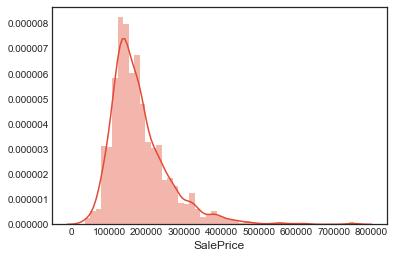

In [4]:
# view distribution of house prices
sns.distplot(full['SalePrice'].dropna(), kde=True) # lognormal; apply transformation before running ML algorithm

In [5]:
##### complete

# view the percentage of missing values for each variable
print((full.isnull().sum() / full.shape[0] * 100).sort_values(ascending=False)) # full.shape[0] returns the no. of rows
print('-'*30)

# check those variables with lots of missing
lots_of_missing = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']
for var in lots_of_missing:
    print(full[var].value_counts())
    print('-'*30)

# seems like missing just means the house doesn't have that facility
for var in lots_of_missing:
    full[var].fillna('None', inplace=True)

PoolQC           99.657417
MiscFeature      96.402878
Alley            93.216855
Fence            80.438506
SalePrice        49.982871
FireplaceQu      48.646797
LotFrontage      16.649538
GarageFinish      5.447071
GarageQual        5.447071
GarageYrBlt       5.447071
GarageCond        5.447071
GarageType        5.378554
BsmtCond          2.809181
BsmtExposure      2.809181
BsmtQual          2.774923
BsmtFinType2      2.740665
BsmtFinType1      2.706406
MasVnrType        0.822199
MasVnrArea        0.787941
MSZoning          0.137033
BsmtFullBath      0.068517
BsmtHalfBath      0.068517
Functional        0.068517
Utilities         0.068517
Exterior2nd       0.034258
Electrical        0.034258
Exterior1st       0.034258
GarageArea        0.034258
KitchenQual       0.034258
SaleType          0.034258
                   ...    
YearRemodAdd      0.000000
YearBuilt         0.000000
WoodDeckSF        0.000000
TotRmsAbvGrd      0.000000
Street            0.000000
ScreenPorch       0.000000
S

In [6]:
##### complete (continued)

# create list of numeric variables with missing values
numeric_cols_with_missing = [] # initialize empty list

for col, col_data in full.iteritems():
    if col_data.isnull().any() and (col_data.dtype=='int' or col_data.dtype=='float'):
        numeric_cols_with_missing.append(col)

# impute numeric variables' missing values with variable medians
for var in numeric_cols_with_missing:
    full[var].fillna(full[var].median(), inplace = True)

# create list of object variables with missing values
object_cols_with_missing = []

for col, col_data in full.iteritems():
    if col_data.isnull().any() and col_data.dtype=='object':
        object_cols_with_missing.append(col)

# impute object variables' missing values with variable modes
for var in object_cols_with_missing:
    full[var].fillna(full[var].mode()[0], inplace = True)

# verify that there are no more missing values
print((full.isnull().sum() / full.shape[0] * 100).sort_values(ascending=False))

# set SalePrice back to missing for test set
full.loc[(full['train_marker']==0),'SalePrice'] = np.nan

train_marker     0.0
EnclosedPorch    0.0
ExterQual        0.0
Exterior1st      0.0
Exterior2nd      0.0
Fence            0.0
FireplaceQu      0.0
Fireplaces       0.0
Foundation       0.0
FullBath         0.0
Functional       0.0
GarageArea       0.0
GarageCars       0.0
GarageCond       0.0
GarageFinish     0.0
GarageQual       0.0
GarageType       0.0
GarageYrBlt      0.0
GrLivArea        0.0
ExterCond        0.0
Electrical       0.0
YrSold           0.0
Condition2       0.0
2ndFlrSF         0.0
3SsnPorch        0.0
Alley            0.0
BedroomAbvGr     0.0
BldgType         0.0
BsmtCond         0.0
BsmtExposure     0.0
                ... 
SaleType         0.0
ScreenPorch      0.0
Street           0.0
TotRmsAbvGrd     0.0
TotalBsmtSF      0.0
Utilities        0.0
WoodDeckSF       0.0
YearBuilt        0.0
YearRemodAdd     0.0
OverallCond      0.0
OpenPorchSF      0.0
Neighborhood     0.0
LotFrontage      0.0
Id               0.0
KitchenAbvGr     0.0
KitchenQual      0.0
LandContour  

In [7]:
##### create

# calculate total square foot of the house
full['TotalSF'] = full['1stFlrSF'] + full['2ndFlrSF']

In [8]:
##### convert

# target encode all object variables
categorical_variables = [] # initialize empty list

for col, col_data in full.iteritems():
    if col_data.dtype==object:
        categorical_variables.append(col) # populate list with the names of all object variables

import category_encoders as ce

targetencode = ce.TargetEncoder(cols = categorical_variables)
targetencode.fit(full,full['SalePrice'])
full = targetencode.transform(full) # replaces the categorical values with the conditional means; no vars created or deleted

# verify that there are no more object variables (recall that sklearn cannot take in object features)
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 83 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
BedroomAbvGr     2919 non-null int64
BsmtFinSF1       2919 non-null float64
BsmtFinSF2       2919 non-null float64
BsmtFullBath     2919 non-null float64
BsmtHalfBath     2919 non-null float64
BsmtUnfSF        2919 non-null float64
EnclosedPorch    2919 non-null int64
Fireplaces       2919 non-null int64
FullBath         2919 non-null int64
GarageArea       2919 non-null float64
GarageCars       2919 non-null float64
GarageYrBlt      2919 non-null float64
GrLivArea        2919 non-null int64
HalfBath         2919 non-null int64
Id               2919 non-null int64
KitchenAbvGr     2919 non-null int64
LotArea          2919 non-null int64
LotFrontage      2919 non-null float64
LowQualFinSF     2919 non-null int64
MSSubClass       2919 non-null int64
MasVnrArea       2919 no

In [9]:
# split the cleaned full dataset into train and test datasets
train = full[(full['train_marker']==1)]
del train['train_marker']

test = full[(full['train_marker']==0)]
del test['train_marker'], test['SalePrice']

# apply log transform to SalePrice
target = np.log(train['SalePrice'])
del train['SalePrice']

In [10]:
##### model building

### view k-fold cross-validation performance of model
from sklearn import model_selection
#from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor

#aloy_xgb1 = XGBClassifier(objective='reg:linear',
#                          eval_metric='rmse')

my_model1 = RandomForestRegressor(n_jobs = -1, # fully utilize the cores on your computer
                                  n_estimators = 250, # number of trees
                                  max_features = "sqrt", # number of features to consider at each split
                                  max_depth = 4) # maximum tree depth

cv_results = model_selection.cross_validate(my_model1,
                                            train,
                                            target,
                                            scoring='neg_mean_squared_error',
                                            cv = 10)

print("the mean training MSE is:", cv_results['train_score'].mean()) # ignore the negative sign
print("the mean validation MSE is:", cv_results['test_score'].mean()) # ignore the negative sign

the mean training MSE is: -0.02459096125457285
the mean validation MSE is: -0.02891486907950579


In [11]:
##### use random search to optimize the hyperparameters, while building the optimal model concurrently
from scipy.stats import randint
from scipy.stats import uniform

param_dist = {'max_depth': randint(3,8), # integer between 3 and 8 inclusive
              'n_estimators': randint(200,300), # integer between 100 and 300 inclusive
              'max_features': ['sqrt']
             }

tune_model = model_selection.RandomizedSearchCV(RandomForestRegressor(n_jobs=-1),
                                                param_distributions=param_dist,
                                                scoring = "neg_mean_squared_error",
                                                cv = 10,
                                                n_iter = 10) # number of iterations of random search

tune_model.fit(train, target)

#print(tune_model.cv_results_['params'])
print('the optimized hyperparameters are: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("after optimization, the mean training MSE is: {:.4f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_])) 
#print(tune_model.cv_results_['mean_test_score'])
print("after optimization, the mean validation MSE is: {:.4f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]))

the optimized hyperparameters are:  {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 277}
after optimization, the mean training MSE is: -0.0101
after optimization, the mean validation MSE is: -0.0205


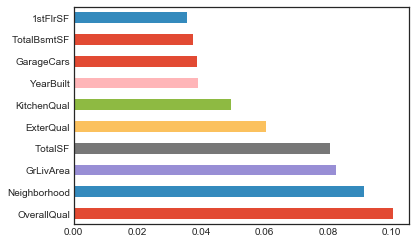

In [13]:
##### use optimized hyperparameters to build random forest
my_rfc = RandomForestRegressor(n_jobs = -1, # fully utilize the cores on your computer
                                n_estimators = tune_model.best_params_['n_estimators'], # number of trees
                                max_features = tune_model.best_params_['max_features'], # number of features to consider at each split
                                max_depth = tune_model.best_params_['max_depth']) # maximum tree depth

# fit the random forest
rf_model1 = my_rfc.fit(train,target)

# view feature importances
feature_importances = pd.Series(rf_model1.feature_importances_, index=train.columns)
feature_importances = feature_importances.sort_values(ascending=False) # sort from highest to lowest importance; for pandas dataframe sorting, refer to https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
feature_importances.nlargest(10).plot(kind='barh')

# use the fitted model to make predictions (remember to exponentiate since we took log just now)
rf_pred1 = np.exp(rf_model1.predict(test))

submission = pd.DataFrame(test_id)
submission['SalePrice'] = rf_pred1
submission.to_csv("../data/kaggle house prices/submission 1.csv", index=False)